In [1]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.tsa.vector_ar.vecm
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
import openpyxl

In [2]:
# Define your path
path = "/Users/v.d Bosch/Documents/Github/GVAR_modelling/"

# Loading data

In [3]:
country_list = openpyxl.load_workbook(path + "Country_data.xlsx").sheetnames
df_country = pd.read_excel(path + "Country_data.xlsx",index_col=0, sheet_name=country_list)
country_list = np.array(country_list)

dom_variable_list = np.array(['y','Dp','eq','ep','r','lr'])
for_variable_list = np.array(['ys','Dps','eqs','eps','rs','lrs'])
variable_list = np.array(['y','Dp','eq','ep','r','lr','ys','Dps','eqs','eps','rs','lrs'])
ext_variable_list = np.array(['Real gross domestic product','Inflation rate','Nominal equity price index','Real exchange rate','Short-term interest rate','Long-term interest rate'])

df_dom = {}
df_for = {}

set_variables = pd.DataFrame(index=variable_list)

for country in country_list:
    df_country[country].index = pd.date_range('1979-04','2020', freq='Q')

    domestic_cols = [col for col in df_country[country].columns if not col.endswith("s")]
    df_dom[country] = df_country[country].loc[:,domestic_cols]
    
    foreign_cols = [col for col in df_country[country].columns if col.endswith("s")]
    df_for[country] = df_country[country].loc[:,foreign_cols]
    
    for variable in variable_list:
        if np.isin(variable, df_country[country].columns):
            set_variables.loc[variable,country] = True
        else:
            set_variables.loc[variable,country] = False

In [4]:
set_variables

,Argentina,Australia,Austria,Belgium,Brazil,Canada,China,Chile,Finland,France,...,South Africa,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,Thailand,Turkey,United Kingdom,United States
y,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Dp,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
eq,True,True,True,True,False,True,False,True,True,True,...,True,False,True,True,True,True,True,False,True,True
ep,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
r,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,True,True,True,True,True
lr,False,True,True,True,False,True,False,False,False,True,...,True,False,False,True,True,True,False,False,True,True
ys,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Dps,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
eqs,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
eps,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [5]:
year_list = ['2014','2015','2016']
df_trade = pd.read_excel(path + "Trading_data.xlsx",index_col=0, sheet_name=year_list)

df_weights = (df_trade['2014'] + df_trade['2015'] + df_trade['2016'])/3

for year in year_list:
    df_weights.fillna(0, inplace=True)
    
for country in country_list:
    df_weights.loc[country] = df_weights.loc[country] / (df_weights.loc[country].sum())



In [6]:
df_weights

,Argentina,Australia,Austria,Belgium,Brazil,Canada,China,Chile,Finland,France,...,South Africa,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,Thailand,Turkey,United Kingdom,United States
Argentina,0.000000,0.008665,0.002063,0.007553,0.265504,0.019327,0.167736,0.034908,0.002260,0.019450,...,0.009254,0.008480,0.002860,0.027472,0.003595,0.016839,0.015505,0.006432,0.014731,0.127333
Australia,0.002311,0.000000,0.003191,0.006511,0.003865,0.008153,0.316774,0.002678,0.001977,0.013372,...,0.004478,0.005235,0.038743,0.007230,0.005583,0.009138,0.041637,0.003134,0.026847,0.096530
Austria,0.001077,0.004666,0.000000,0.023828,0.003943,0.006292,0.039477,0.001176,0.004669,0.046809,...,0.003370,0.004741,0.002215,0.020448,0.013495,0.076398,0.003128,0.013682,0.032727,0.056016
Belgium,0.001380,0.004665,0.009805,0.000000,0.009555,0.008159,0.037591,0.001911,0.007168,0.155654,...,0.006535,0.006234,0.011449,0.027966,0.021245,0.016505,0.004056,0.014505,0.083659,0.083658
Brazil,0.083325,0.004864,0.003656,0.016222,0.000000,0.015844,0.228286,0.026367,0.003118,0.024419,...,0.006013,0.016003,0.011189,0.021386,0.005999,0.014832,0.011925,0.006638,0.020398,0.182179
Canada,0.002178,0.003611,0.002098,0.005405,0.005994,0.000000,0.085512,0.002731,0.001779,0.009769,...,0.001506,0.003504,0.002454,0.003732,0.002460,0.005817,0.003997,0.002522,0.025182,0.688913
Chile,0.005259,0.045174,0.003025,0.009534,0.029807,0.019124,0.000000,0.012846,0.002974,0.020563,...,0.016752,0.021652,0.030529,0.010953,0.005268,0.013094,0.029636,0.008466,0.030890,0.214996
China,0.031073,0.007480,0.002896,0.010668,0.077263,0.018019,0.283972,0.000000,0.003968,0.026821,...,0.001712,0.001863,0.001324,0.024979,0.004681,0.008171,0.009313,0.005000,0.011791,0.180274
Finland,0.001977,0.006114,0.013680,0.043957,0.009925,0.011597,0.056813,0.004494,0.000000,0.043882,...,0.005830,0.004492,0.003190,0.024368,0.184213,0.014717,0.003754,0.012743,0.057408,0.065657
France,0.001874,0.004305,0.012510,0.114731,0.009202,0.007205,0.056643,0.002033,0.004769,0.000000,...,0.003320,0.012125,0.009685,0.088556,0.014867,0.039569,0.004289,0.016234,0.070185,0.077206


# Plot variables

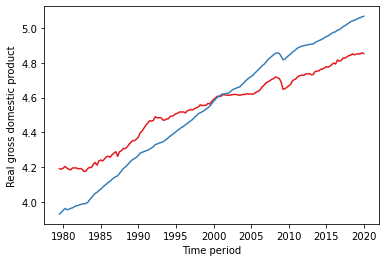

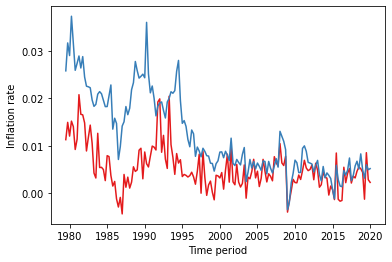

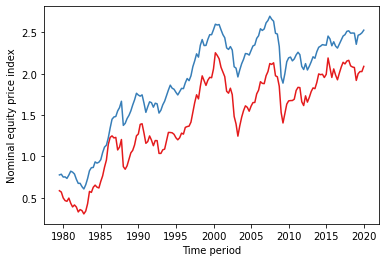

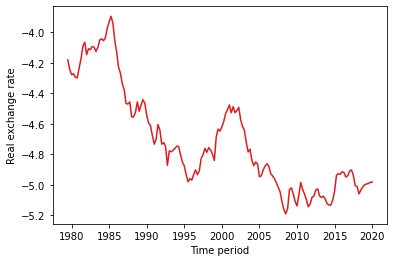

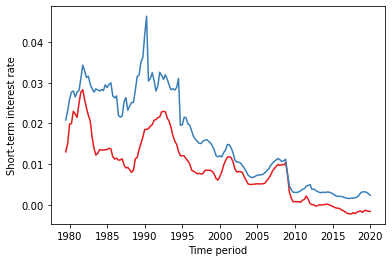

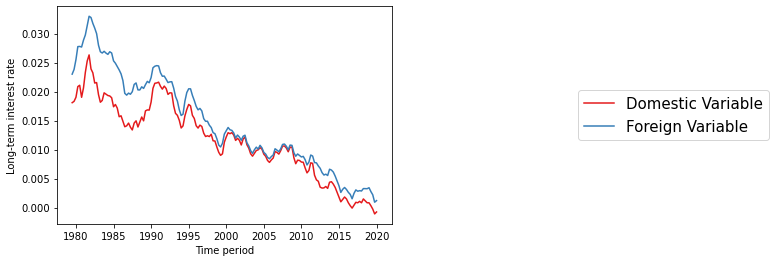

In [7]:
# Define a country
country = 'Germany'

sns.set_palette("Set1")

# Plot x_it and x_star for every variable
for i in range(len(ext_variable_list)-1):
    if set_variables[country][variable_list[i]]:
        plt.plot(df_dom[country][variable_list[i]])
    
    if set_variables[country][variable_list[i]+"s"]:
        plt.plot(df_for[country][variable_list[i]+"s"])
    
    plt.xlabel("Time period")
    plt.ylabel(ext_variable_list[i])
        
    plt.show()


fig, ax = plt.subplots()

sns.lineplot(data=df_dom[country][variable_list[5]],label='Domestic Variable')
sns.lineplot(data=df_for[country][variable_list[5]+"s"],label='Foreign Variable')
    
plt.xlabel("Time period")
plt.ylabel(ext_variable_list[5])
    
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(2.15, 0.5),prop={'size':15})

plt.show()

# Test order of integration

In [8]:
# Define the DataFrames to fill the results in
adf_test_diff0 = pd.DataFrame(index=dom_variable_list)
adf_test_diff1 = pd.DataFrame(index=dom_variable_list)
adf_test_diff2 = pd.DataFrame(index=dom_variable_list)

# Loop over every country and variable
for country in country_list:
    for variable in dom_variable_list:
        if set_variables[country][variable]:
            # Take the data and its first and second difference
            non_dif = df_dom[country][variable]
            first_dif = np.diff(non_dif)
            second_dif = np.diff(first_dif)
        
            # Fill the DataFrames with the adf test statistics
            adf_test_diff0.loc[variable,country] = round(sm.tsa.stattools.adfuller(non_dif, autolag= 'AIC',regression='ct')[1],4)
            adf_test_diff1.loc[variable,country] = round(sm.tsa.stattools.adfuller(first_dif, autolag= 'AIC',regression='ct')[1],4)
            adf_test_diff2.loc[variable,country] = round(sm.tsa.stattools.adfuller(second_dif, autolag= 'AIC',regression='ct')[1],4)

In [9]:
# adf_test_diff0
# adf_test_diff1
# adf_test_diff2

# Determine lag order

In [10]:
max_lag = 8

for country in country_list:
    
    # Define the current lowest BIC value
    min_bic = 1000000
    
    # Loop over all possible combinations
    for lag_x_it in range(1,max_lag+1):
        for lag_x_star in range(1,max_lag+1):
            
            # Initialize a dataframe with the x_star values of lag 0
            df_parameter = pd.concat([df_for[country]])
            df_parameter.columns += "_L0"
            
            # Loop over all lag_x_it values to add the lagged values of x_it to df_parameter
            for lag in range(1,lag_x_it+1):
                lagged_x_it = df_dom[country].shift(lag)
                lagged_x_it.columns += "_L"+str(lag) 
                df_parameter = pd.concat([df_parameter,lagged_x_it], axis=1)
            
            # Loop over all lag_x_star values to add the lagged values of x_star to df_parameter
            for lag in range(1,lag_x_star+1):
                lagged_x_star = df_for[country].shift(lag)
                lagged_x_star.columns += "_L"+str(lag) 
                df_parameter = pd.concat([df_parameter,lagged_x_star], axis=1)
    
            # Create and fit the model
            model = VAR(endog = df_dom[country].iloc[max_lag:], exog = df_parameter.iloc[max_lag:])
            results = model.fit(maxlags=0,trend='ct')
                        
            # Update the lag and BIC value if the BIC value is smaller
            if (results.bic < min_bic):
                min_bic = results.bic
                best_lag_bic = (lag_x_it,lag_x_star)
    
    print("For",country)
    print("The lag order by BIC is",best_lag_bic)
    print("The BIC value is",min_bic)
    print("")

For Argentina
The lag order by BIC is (2, 1)
The BIC value is -23.337819956235293

For Australia
The lag order by BIC is (1, 1)
The BIC value is -57.733511203195626

For Austria
The lag order by BIC is (1, 1)
The BIC value is -60.83426557220619

For Belgium
The lag order by BIC is (1, 1)
The BIC value is -60.587925235562494

For Brazil
The lag order by BIC is (1, 2)
The BIC value is -23.83150251501707

For Canada
The lag order by BIC is (1, 1)
The BIC value is -62.66971079552296

For China
The lag order by BIC is (1, 1)
The BIC value is -37.626616398144954

For Chile
The lag order by BIC is (1, 1)
The BIC value is -36.45281350051648

For Finland
The lag order by BIC is (1, 1)
The BIC value is -43.2240841969497

For France
The lag order by BIC is (1, 1)
The BIC value is -62.64468269270999

For Germany
The lag order by BIC is (1, 1)
The BIC value is -62.4295606405708

For India
The lag order by BIC is (1, 1)
The BIC value is -39.34971583519152

For Indonesia
The lag order by BIC is (3, 1

# Fitting the model

In [117]:
# Define the chosen lag
lag_x_it = 1
lag_x_star = 1
max_lag = max(lag_x_it,lag_x_star)

# Define two dictionaries for the parameter estimates and residuals
df_estimates = {}
resid_dict = {}

# Loop over all countries
for country in country_list:
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([df_for[country]])
    df_country.columns += "_L0"
            
    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,lag_x_it+1):
        lagged_x_it = df_dom[country].shift(lag)
        lagged_x_it.columns += "_dom_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_it], axis=1)
            
    # Loop over all lag_x_star values to add the lagged values of x_star to df_country
    for lag in range(1,lag_x_star+1):
        lagged_x_star = df_for[country].shift(lag)
        lagged_x_star.columns += "_for_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_star], axis=1)

    # Create and fit the model
    model = VAR(endog = df_dom[country].iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct')

    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params.T

    # Fill the residuals of the VARX model in the dictionary
    resid_dict[country] = results.resid

In [118]:
# selected_cols = [col for col in df_estimates[country].columns if col.endswith("_L0")]
# df_estimates["Argentina"]#.loc[:,selected_cols]

# selected_cols = [col for col in df_estimates[country].columns if col.endswith("m_L1")]
            
# lambda_i = df_estimates[country].loc[:,selected_cols]
# np.linalg.eigvals(lambda_i)
df_estimates["Argentina"]

,const,trend,ys_L0,Dps_L0,eqs_L0,rs_L0,lrs_L0,y_dom_L1,Dp_dom_L1,eq_dom_L1,ep_dom_L1,r_dom_L1,ys_for_L1,Dps_for_L1,eqs_for_L1,rs_for_L1,lrs_for_L1
y,0.229285,0.000400,0.472997,-0.175724,0.033858,0.109425,-1.714623,0.953273,-0.012281,0.010831,0.005137,-0.010610,-0.471943,0.305955,-0.045985,-0.211001,1.159060
Dp,1.291457,0.004158,-1.167375,-1.754068,0.098854,1.994996,30.245470,0.212135,-0.305123,0.027148,0.210341,1.151972,0.680602,-0.235489,0.051489,0.506688,-17.168819
eq,-11.998889,-0.034419,6.407746,0.003628,1.294704,0.516592,5.349369,-0.202396,0.439604,0.815980,-0.100976,-0.065824,-3.012578,-0.579391,-1.308308,-0.729701,-17.825962
ep,-5.728220,-0.012305,-0.881058,-0.997137,-0.065791,0.763894,44.433096,-0.089784,-0.119734,-0.114554,1.029487,-0.274803,2.459835,-0.814998,0.012954,0.925621,-28.513148
r,-3.097359,-0.009108,-1.956741,-3.532297,0.092914,2.817346,45.541142,0.218837,-0.150378,-0.052125,0.279794,0.188585,2.746651,1.654329,0.043503,-0.285892,-31.521850


# Stack the VARX* models

In [258]:
dom_variables = np.array([])

for country in country_list:
    for variable in dom_variable_list:
        if set_variables[country][variable]:
            dom_variables = np.append(dom_variables,[str(variable)+"_"+str(country)])

for_variables = np.array([])

for country in country_list:
    for variable in for_variable_list:
        if set_variables[country][variable]:
            for_variables = np.append(for_variables,[str(variable)+"_"+str(country)])

    
k_i = {}
k_star = {}
k = 0

for country in country_list:
    k_i[country] = set_variables[country][dom_variable_list].sum()
    k_star[country] = set_variables[country][for_variable_list].sum()
    k += k_i[country]

In [259]:
# Stack all a_i0 parameters
matrix_col = []
for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"const"])
a_0 = pd.concat(matrix_col)

# Stack all a_i1 parameters
matrix_col = []

for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"trend"])
a_1 = pd.concat(matrix_col)

# Stack all residuals
epsilon_t = pd.concat(resid_dict.values(), axis=1).T

In [260]:
def create_G_j(j):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        current_dom_variables = np.array(dom_variable_list)[set_variables.loc[dom_variable_list][country].tolist()]
        
        # Create E_i
        E_i = np.zeros((k_i[country],k))
        
        k_i_count = 0
        for variable in dom_variable_list:
            if set_variables[country][variable]:
                i = np.where(dom_variables == (str(variable)+"_"+str(country)))[0][0]
                E_i[k_i_count][i] = 1
                k_i_count += 1
        
        # Create W_i
        W_i = np.zeros((k_star[country],k))

        for W_country in country_list:

            k_i_count = 0
            
            for W_variable in for_variable_list:
                
                if (set_variables[W_country][W_variable[:-1]] and set_variables[country][W_variable]):
                    
                    i = np.where(dom_variables == (str(W_variable)[:-1]+"_"+str(W_country)))[0][0]
                    W_i[k_i_count][i] = df_weights[W_country][country]
                    k_i_count += 1
                
                elif (set_variables[country][W_variable]):
                    k_i_count += 1

        W_i = W_i / W_i.sum(1)[:,np.newaxis]
        
        # Create Omega_i
        Omega_i = np.vstack((E_i,W_i))

        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i[country]),-lambda_i))

        else:
            
            if (lag_x_it < j):
                phi_i = np.zeros((k_i[country],k_i[country]))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("dom_L"+str(j))]
                phi_i = df_estimates[country].loc[:,selected_cols]
                
            if (lag_x_star < j):
                lambda_i = np.zeros((k_i[country],k_star[country]))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("for_L"+str(j))]
                lambda_i = df_estimates[country].loc[:,selected_cols]
                
            A_i = np.hstack((phi_i,lambda_i))
        

        # Finally, compute G_i by A_i and Omega_i

        G_i = A_i @ Omega_i
        
        matrix_col.append(G_i)
        
    # Return G_j
    return np.vstack(matrix_col)

In [261]:
def x_t(l,t): 
    return pd.concat([df_dom[country] for country in country_list],axis=1).T.iloc[:,max_lag+t-l]

t = 1
(create_G_j(0) @ x_t(0,t) - a_0 - a_1 * (t+1) - create_G_j(1) @ x_t(1,t))

y     -2.224295
Dp     6.013973
eq   -15.409156
ep     9.610978
r      7.289565
        ...    
y     -0.714134
Dp     0.098470
eq    -9.987516
r     -0.082678
lr    -0.057007
Length: 174, dtype: float64

In [262]:
epsilon_t

,1979-12-31,1980-03-31,1980-06-30,1980-09-30,1980-12-31,1981-03-31,1981-06-30,1981-09-30,1981-12-31,1982-03-31,...,2017-09-30,2017-12-31,2018-03-31,2018-06-30,2018-09-30,2018-12-31,2019-03-31,2019-06-30,2019-09-30,2019-12-31
y,-0.007704,0.004423,-0.029345,-0.016486,-0.004873,-0.005863,0.001293,-0.007121,0.006077,0.007236,...,0.004929,0.004832,-0.003590,-0.065679,0.049655,-0.023537,0.015947,-0.003840,-0.002671,-0.003278
Dp,0.070538,0.050971,0.126077,0.059846,0.042728,0.061152,0.021660,-0.056517,-0.127367,-0.014874,...,0.033151,0.011866,0.039752,0.021881,-0.022028,0.025162,-0.025682,0.022631,0.001672,0.006718
eq,-0.357751,0.049810,0.544089,-0.320078,-0.027001,-0.147592,0.325993,-0.479434,-0.290850,0.269935,...,-0.000617,0.136377,-0.009566,-0.249071,-0.182830,-0.231983,0.146574,-0.065595,-0.132692,-0.374473
ep,0.125686,-0.067105,-0.040695,-0.030275,-0.187907,-0.058530,0.257870,-0.025042,-0.115025,0.016008,...,0.042851,-0.044861,0.056676,0.059770,-0.003951,-0.003311,-0.117111,-0.014682,0.004113,-0.011440
r,0.117730,-0.018648,0.033082,0.055732,-0.023153,0.087468,0.079438,0.061343,-0.089680,-0.090599,...,0.059866,0.041882,0.068723,0.037776,-0.052889,0.027244,-0.006934,0.051685,0.043118,0.028553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
y,0.003190,0.002247,-0.019919,0.009818,0.013507,0.004631,-0.013039,0.010120,-0.013374,-0.014642,...,-0.002588,0.001285,-0.000992,0.003349,-0.001106,-0.006370,0.006320,-0.005273,-0.000451,0.001073
Dp,0.004715,0.008813,0.004583,0.001988,0.008240,-0.003524,-0.001592,0.004075,-0.009123,-0.002553,...,0.003001,0.003461,0.003106,-0.001660,0.000019,-0.001344,-0.000303,0.001068,-0.000174,0.001418
eq,-0.062811,0.011749,0.017583,0.070498,0.039334,-0.028531,-0.043967,-0.097204,-0.036269,-0.076157,...,0.012768,0.017594,-0.044860,0.023334,0.045314,-0.183563,0.106994,-0.036071,-0.050644,0.009156
r,0.004093,0.001757,-0.008550,0.000633,0.007934,0.000032,0.000754,0.000214,-0.006315,0.003303,...,-0.000764,0.000839,0.000443,0.000344,-0.000541,0.000237,0.000763,-0.000786,-0.000523,-0.000938


In [263]:
# Calculate the inverse of G_0
G_0_inv = np.linalg.inv(create_G_j(j=0))

# Create a dictionary for the values of F_l
F_l_dict = {}

# Fill dictionary by computing the values of F_l 
for j in range(max_lag+1):
    F_l_dict[j] = G_0_inv @ create_G_j(j=j)

In [264]:
# Method to compute R_h for a given h
def calculate_R_h(h, memo={}):
    if h in memo:
        return memo[h]

    if h < 0:
        memo[h] = np.zeros((k,k))
    elif h == 0:
        memo[h] = np.eye(k)
    else:
        memo[h] = sum([F_l_dict[l] @ calculate_R_h(h-l) for l in range(1,max_lag+1)])
    
    return memo[h]

In [265]:
def perform_GIRF(max_h,shock,country_choice,variable_choice):
    
    # Get the index of the country and variable of the shock and define e_j
    e_j = np.zeros((k,1))
    e_j[np.where(dom_variables == shock)[0][0]] = 1
    
    # Compute Sigma
    Sigma = np.cov(epsilon_t)

    # Initialize an empty array for the index and names of the chosen countries and variables
    index_array = []
    name_array = []
    
    # Loop over all chosen countries and variables and append to arrays
    for country in country_choice:
        if set_variables[country][variable_choice]:
            name_array.append(str(variable_choice)+"_"+str(country))
#         print(name_array)
#         country_i = np.where(country_list == country)[0][0]
#         variable_i = np.where(variable_list == variable_choice)[0][0]
        np.where(dom_variables == shock)
        
        if set_variables[country][variable_choice]:
            index_array.append(np.where(dom_variables == str(variable_choice)+"_"+str(country))[0][0])
#         name_array.append(country)
    
    # Calculate the GIRF for every h
    girf_matrix = np.hstack([calculate_R_h(h) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])
    
    # Make a dictionary for the specific country color and line kind
#     country_color = {}
#     country_line = {}
#     for i in range(len(country_list)):
#         country_color[country_list[i]] = ['#ff7f00','#377eb8','#377eb8', '#4daf4a', '#4daf4a', '#4daf4a','#984ea3','#984ea3', '#ff7f00', '#e41a1c', '#4daf4a',  '#4daf4a','#377eb8'][i]
#         country_line[country_list[i]] = ['-','-','--','-','--',':','-','--','--','-','-.',(0, (5, 1)),':'][i]
    
    # Plot all GIRF in a plot
    for i in range(len(index_array)):
        sns.lineplot(x=np.arange(max_h+1),y=girf_matrix[index_array[i]],label=name_array[i])
    plt.plot()

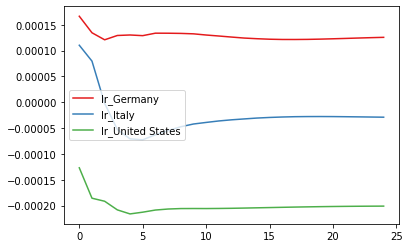

In [277]:
# Define the country and variable of the shock
shock = "r_Japan"


# Define the countries and variables that should be in the IRF
new_country_list = np.array(['Germany','Italy','Finland','United States'])
country_choice = new_country_list
variable_choice = "lr"

# Define the length of h
max_h = 24

perform_GIRF(max_h,shock,country_choice,variable_choice)

In [204]:
for country in country_list:
    selected_cols = [col for col in df_estimates[country].columns if col.endswith("m_L2")]

    matrix = df_estimates[country].loc[:,selected_cols]
    print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))

(-0.3061333272456462-0.36902816121015214j) (0.45593375128899005+0j)
(-0.01309988416348711-0.10998197902585612j) (0.11328286733277347+0.06445535264645551j)
(-0.1764389022521186-0.08517242699688504j) (0.20987487238211006+0.1307662763025144j)
(-0.2605819955783945+0j) (0.23734623750034475+0j)
(-0.15330604628939182-0.1591220227110509j) (0.3224781927369026+0j)
(-0.23686275426862374+0j) (0.300934708051041+0j)
(-0.3037273652378943+0j) (0.21637731716083314+0j)
(-0.20521327000177275-0.09561585600004917j) (0.30330427074480304+0j)
(-0.11522011590615579-0.07064866123942125j) (0.29159336778793477+0j)
(-0.17490022365474325+0j) (0.23569884514635953+0j)
(-0.14783385916043365+0j) (0.3018222888168915+0j)
(-0.3103113291836549+0j) (0.2495530074822318+0j)
(-0.3317193576100003-0.0877456129827936j) (0.4142031173078614+0j)
(-0.0817424542008645-0.21511767633006434j) (0.3272240541910278+0.0936925026764107j)
(-0.17122947347576703+0j) (0.40050708881101993+0j)
(-0.2821222237415816+0j) (0.11352594725612268+0.2658924

In [257]:
df_estimates = {}
resid_dict = {}

country = "United States"
# for rank in [3]:
for country in country_list:
    # Define the chosen lag
    lag_x_it = 2
    lag_x_star = 1
    max_lag = max(lag_x_it,lag_x_star)
    
    x_it_star = pd.concat([df_dom[country],df_for[country]],axis=1)
    
    eigenvalues = statsmodels.tsa.vector_ar.vecm.coint_johansen(x_it_star,det_order=-1,k_ar_diff=max_lag-1).eig

    # Determine the rank of cointegration
    rank = np.sum(np.cumsum(eigenvalues) < 1)

    if (rank > 5):
        rank = 5
    
    coin_result = statsmodels.tsa.vector_ar.vecm.VECM(endog= df_dom[country][1:],exog=df_for[country].diff(1)[1:],exog_coint=df_for[country][1:],coint_rank=rank,k_ar_diff=max_lag-1).fit()
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([df_dom[country].shift(1),df_for[country].shift(1)], axis=1) @ np.vstack([coin_result.beta,coin_result.det_coef_coint])
    df_country.columns = ["_" + str(i) +"_coin" for i in range(coin_result.beta.shape[1])]

    # Initialize a dataframe with the x_star values of lag 0
    lagged_x_star = pd.concat([df_for[country]],axis=1)
    lagged_x_star.columns += "_L0"
    df_country = pd.concat([df_country,lagged_x_star],axis=1)
            
    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,lag_x_it+1):
        if (lag <= lag_x_it-1):
            lagged_x_it = df_dom[country].diff(1).shift(lag)
            lagged_x_it.columns += "_dom_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_it], axis=1)
            
    # Loop over all lag_x_star values to add the lagged values of x_star to df_country
    for lag in range(1,lag_x_star+1):
        if (lag <= lag_x_star-1):
            lagged_x_star = df_for[country].shift(lag)
            lagged_x_star.columns += "_for_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_star], axis=1)
        
    
    # Create and fit the model
    model = VAR(endog = df_dom[country].diff(1).iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct',method='ols')
    
#     print(results.params.T)
    
    df_estimate =  results.params.T.loc[:,["const","trend"]]
    
    selected_cols = [col for col in results.params.T.columns if col.endswith("L0")]
    new_df = results.params.T.loc[:,selected_cols]
    new_df.columns = [str(variable) + "_L0" for variable in for_variable_list if set_variables[country][variable]]
    df_estimate = pd.concat([df_estimate,new_df],axis=1)
    
    
    selected_cols = [col for col in results.params.T.columns if col.endswith("L1")]
    new_df = results.params.T.loc[:,selected_cols]
    new_df.columns = [str(variable) + "_dom_L2" for variable in dom_variable_list if set_variables[country][variable]]
    df_estimate = pd.concat([df_estimate,-new_df],axis=1)
    
    
    selected_cols = [col for col in df_estimate.columns if col.endswith("_L0")]
    A_0 = np.hstack([np.eye(k_i[country]),-df_estimate.loc[:,selected_cols]])
    
    selected_cols = [col for col in df_estimate.columns if col.endswith("_L2")]
    A_2 = np.hstack([df_estimate.loc[:,selected_cols],np.zeros((k_i[country],k_star[country]))])
#     print("A_0")
    print(A_0.shape)
#     print("A_2")
    print(A_2.shape)
    
    selected_cols = [col for col in results.params.T.columns if col.endswith("coin")] 
    new_df = results.params.T.loc[:,selected_cols] @ np.vstack([coin_result.beta,coin_result.det_coef_coint]).T
    new_df.columns = [str(variable) + "_dom_L1" for variable in dom_variable_list if set_variables[country][variable]] + [str(variable) + "_for_L1" for variable in for_variable_list if set_variables[country][variable]]
    df_estimate = pd.concat([df_estimate,new_df+A_0-A_2],axis=1)
    
#     print(country)
#     print(df_estimate)
    
    df_estimates[country] = df_estimate
    resid_dict[country] = results.resid
#     selected_cols = [col for col in df_estimate.columns if col.endswith("_dom_L1")]

#     matrix = df_estimate.loc[:,selected_cols]
#     print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))
# results.params.T
# selected_cols = [col for col in results.params.T.columns if col.endswith("dom_L1")]

# matrix = results.params.T.loc[:,selected_cols]
#     print(df_estimate)
    
#     selected_cols = [col for col in df_estimate.columns if col.endswith("for_L0")]

#     matrix =  df_estimate.loc[:,selected_cols]

#     print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))
    selected_cols = [col for col in df_estimates[country].columns if col.endswith("m_L1")]

    matrix = df_estimates[country].loc[:,selected_cols]
    print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))
df_estimates[country]

(5, 10)
(5, 10)
(0.32430599314988157-0.1596806365732129j) (1.4778213005670715+0j)
(6, 11)
(6, 11)
(0.05533874466383093+0j) (1.2189817321080163+0j)
(6, 11)
(6, 11)
(0.11766893899847053+0j) (1.2210601328320876+0.0485810896781405j)
(6, 11)
(6, 11)
(0.23547367488797005+0j) (1.241016011584141+0.08101525132703183j)
(4, 9)
(4, 9)
(0.6292696296773873-0.7507229414288455j) (1.330139018438553+0j)
(6, 11)
(6, 11)
(0.3573803357491198+0j) (1.117416019892891+0j)
(4, 9)
(4, 9)
0.6065603356208953 1.289380529737506
(5, 10)
(5, 10)
(0.2343325641521709+0j) (1.240787838293307+0.0288540005353071j)
(5, 10)
(5, 10)
(0.3409949333222443+0j) (1.132202435291775+0.0811063278500469j)
(6, 11)
(6, 11)
(0.2784241410428644+0j) (1.3253986311207984+0j)
(6, 11)
(6, 11)
(-0.01776821778465787+0j) (1.3051584599011004+0.14948507371425857j)
(5, 10)
(5, 10)
0.19462438003590599 1.298081510948809
(4, 9)
(4, 9)
0.3084241181797397 1.2793710044852002
(6, 11)
(6, 11)
(0.42924412014344787+0j) (1.236288193188145+0.037412351370928056j)


,const,trend,ys_L0,Dps_L0,eps_L0,y_dom_L2,Dp_dom_L2,eq_dom_L2,r_dom_L2,lr_dom_L2,y_dom_L1,Dp_dom_L1,eq_dom_L1,r_dom_L1,lr_dom_L1,ys_for_L1,Dps_for_L1,eps_for_L1
y,0.042957,0.000103,-0.010119,0.028269,0.000921,-0.162875,0.035573,-0.029095,-1.284617,0.832748,1.155391,-0.181718,0.034936,0.782811,0.144822,0.013712,0.001605,-0.000907
Dp,-0.069185,-0.000166,0.019317,0.062920,0.001900,0.013403,0.064837,-0.009460,-0.393778,-0.902390,-0.009956,0.270916,0.003314,1.159200,0.143724,-0.020526,-0.104055,-0.005060
eq,2.768418,0.007388,-0.836152,-0.169571,-0.159473,-1.857421,-1.946460,-0.089080,6.395825,4.789077,1.901010,-0.852698,1.037819,-0.807311,-12.021306,0.817448,-0.141015,0.143660
r,-0.008615,-0.000014,0.002350,0.011719,0.000514,-0.021584,0.130784,-0.005491,-0.187037,-0.128426,0.021743,-0.075014,0.005615,1.159235,0.129857,-0.002459,-0.010383,-0.000288
lr,-0.004848,-0.000014,0.002035,0.003207,0.001089,-0.014095,0.028654,-0.004142,0.063713,-0.327878,0.015926,-0.014513,0.002611,0.074841,1.079600,-0.002901,-0.011325,-0.001186


In [57]:
results.params.T
selected_cols = [col for col in results.params.T.columns if col.endswith("m_diff_L1")]

matrix = results.params.T.loc[:,selected_cols]
print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))

(-0.4668334105423843+0j) (0.3927129237702468+0j)


In [800]:
df_estimates["Netherlands"]

,const,trend,ys_L0,Dps_L0,eqs_L0,rs_L0,lrs_L0,y_dom_L2,Dp_dom_L2,eq_dom_L2,...,Dp_dom_L1,eq_dom_L1,ep_dom_L1,r_dom_L1,lr_dom_L1,ys_for_L1,Dps_for_L1,eqs_for_L1,rs_for_L1,lrs_for_L1
y,0.228194,0.000333,0.331035,-0.072297,0.019212,0.031607,1.049966,0.057790,-0.086152,-0.015652,...,-0.023131,0.018056,-0.025123,0.816196,-1.330500,-0.705502,0.217662,-0.025171,-0.191304,-1.114550
Dp,-0.043365,-0.000034,-0.006587,0.507945,-0.000174,-0.295738,0.379528,0.018573,0.208678,-0.001080,...,0.099582,0.009664,0.010306,0.481284,0.411770,0.034615,-0.483665,-0.008726,0.064352,-0.676549
eq,1.939648,0.002698,-0.018510,0.459070,1.001657,-1.129014,3.898272,-0.796141,0.967689,0.029504,...,1.366994,0.927230,0.122627,-3.400068,-7.103522,-0.099564,-0.900946,-1.885110,0.811178,-5.622797
ep,0.434581,0.000390,-0.713142,0.583414,0.084408,-2.312277,0.494301,-0.943924,1.867773,0.039896,...,3.638144,-0.096847,1.210335,-2.387268,-19.273629,1.203009,-2.254008,-0.062843,4.743743,7.180343
r,-0.011224,0.000008,0.029843,-0.083134,0.001929,0.192922,0.321726,-0.002798,-0.005756,-0.002041,...,-0.028978,0.002800,0.001026,1.187175,0.059447,-0.064075,0.219596,-0.004201,-0.419620,-0.491629
lr,-0.018693,-0.000021,-0.004232,0.011895,0.000201,0.001375,0.930857,0.010746,0.005229,-0.000443,...,0.005898,0.000850,-0.000852,0.025865,0.794814,0.007140,-0.037686,-0.000656,0.014870,-1.650174


In [91]:
df_estimates["United States"]

,const,trend,_0_coin,_1_coin,ys_L0,Dps_L0,eps_L0
y,0.057654,1.366800e-04,0.007286,0.150346,-0.012940,0.030925,0.002157
Dp,-0.054705,-1.441089e-04,-0.002222,0.590212,0.016442,0.046197,0.002422
eq,2.774616,7.429919e-03,-0.021234,1.912432,-0.813425,0.047626,-0.121068
r,0.000215,3.420223e-06,-0.000300,-0.002823,-0.000419,0.003006,-0.000460
lr,0.000930,2.378234e-07,-0.001536,-0.018125,0.000130,0.000858,0.000417


In [617]:
country = "Japan"

W_i = np.zeros((k_star[country],k))

for W_country in country_list:
    
    k_i_count = 0
    
    for W_variable in for_variable_list:
        if set_variables[country][W_variable] and set_variables[W_country][W_variable]:
            i = np.where(for_variables == (str(W_variable)+"_"+str(W_country)))[0][0]
            W_i[k_i_count][i] = df_weights[W_country][country]
        
#         elif (set_variables[country][W_variable]):
#             k_i_count += 1

W_i = W_i / W_i.sum(1)[:,np.newaxis]
print(W_i@x_t(0,0))


[0.04899824        nan        nan        nan        nan]


<ipython-input-617-f8448213e00d>:17: RuntimeWarning: invalid value encountered in true_divide
  W_i = W_i / W_i.sum(1)[:,np.newaxis]


In [621]:
country = "Japan"

W_i = np.zeros((k_star[country],k))
for W_country in country_list:

    k_i_count = 0
#     print(W_country)  
    for W_variable in for_variable_list:
        
        if (set_variables[W_country][W_variable[:-1]] and set_variables[country][W_variable]):
#             print("YES:  ",W_variable)
            i = np.where(dom_variables == (str(W_variable)[:-1]+"_"+str(W_country)))[0][0]
#             print(i)
            W_i[k_i_count][i] += df_weights[W_country][country]
            k_i_count += 1
        elif (set_variables[country][W_variable]):
            k_i_count += 1

#             print("NO:  ",W_variable)
# print(W_i)

W_i = W_i / W_i.sum(1)[:,np.newaxis]
print(W_i@x_t(0,0))
# print(x_t(0,0))

# aaa= np.zeros((175,5))

for i in range(1,175):
    aaa[i] = aaa[i-1] + W_i[:,i-1] * x_t(0,0)[i-1]
#     break;
# sns.lineplot(data=aaa[:,0])

[3.50618746 0.02584482 0.67025564 0.02241386 0.02706011]


In [135]:
df_estimates = {}
resid_dict = {}

for country in ["Japan"]:
    # Define the chosen lag
    lag_x_it = 2
    lag_x_star = 2
    max_lag = max(lag_x_it,lag_x_star)
    
    x_it_star = pd.concat([df_dom[country],df_for[country]],axis=1)
    
    rank = statsmodels.tsa.vector_ar.vecm.select_coint_rank(x_it_star,det_order=-1,k_ar_diff=max_lag-1).rank-1
    
    if (rank > 5):
        rank = 5
    
#     print(rank)
    
    coin_result = statsmodels.tsa.vector_ar.vecm.VECM(endog= df_dom[country],exog=df_for[country],exog_coint=df_for[country],k_ar_diff=max_lag-1,coint_rank=rank).fit()

    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([-df_dom[country].shift(1),-df_for[country].shift(1)], axis=1) @ np.vstack([coin_result.beta,coin_result.det_coef_coint])
    df_country.columns = ["var_" + str(i) for i in range(coin_result.beta.shape[1])]

    # Initialize a dataframe with the x_star values of lag 0
    lagged_x_star = pd.concat([df_for[country]],axis=1)
    lagged_x_star.columns += "_L0"
    df_country = pd.concat([lagged_x_star],axis=1)
    
    
    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,lag_x_it+1):
        if (lag <= lag_x_it-1):
            lagged_x_it = df_dom[country].diff(1).shift(lag)
            lagged_x_it.columns += "_dom_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_it], axis=1)
            
    # Loop over all lag_x_star values to add the lagged values of x_star to df_country
    for lag in range(1,lag_x_star+1):
        if (lag <= lag_x_star-1):
            lagged_x_star = df_for[country].shift(lag)
            lagged_x_star.columns += "_for_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_star], axis=1)
        
    
    # Create and fit the model
    model = VAR(endog = df_dom[country].diff(1).iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct',method='ols')

    
    df_estimate =  results.params.T.loc[:,["const","trend"]]

    selected_cols = [col for col in results.params.T.columns if col.endswith("L0")]
    new_df = results.params.T.loc[:,selected_cols]
    new_df.columns = [str(variable) + "_L0" for variable in for_variable_list if set_variables[country][variable]]
    df_estimate = pd.concat([df_estimate,new_df],axis=1)
    
    
    A_0 = np.hstack([np.eye(k_i[country]),-new_df.loc[:,selected_cols]])
    selected_cols = [col for col in results.params.T.columns if col.endswith("L1")]
    new_df = results.params.T.loc[:,selected_cols]
    new_df.columns = [str(variable) + "_dom_L2" for variable in dom_variable_list if set_variables[country][variable]] + [str(variable) + "_for_L2" for variable in for_variable_list if set_variables[country][variable]]
    df_estimate = pd.concat([df_estimate,-new_df+A_0],axis=1)
    
    df_estimates[country] = df_estimate
df_estimates[country]

# x_star.diff(1)
# coin_result.summary()
#     matrix = coin_result.det_coef
#     print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))
# print(matrix)

,const,trend,ys_L0,Dps_L0,eqs_L0,rs_L0,lrs_L0,y_dom_L2,Dp_dom_L2,eq_dom_L2,ep_dom_L2,r_dom_L2,lr_dom_L2,ys_for_L2,Dps_for_L2,eqs_for_L2,rs_for_L2,lrs_for_L2
y,0.066280,0.000425,0.663444,0.059857,0.001614,-0.422307,-0.702220,0.927325,-0.015966,-0.018011,-0.004417,-0.763795,-0.526399,0.025262,-0.088137,0.000947,-0.002855,-0.616693
Dp,0.005200,0.000032,0.167514,0.158231,0.011200,-0.089379,0.310416,-0.083390,1.438294,0.006626,-0.023233,0.092660,-0.670515,0.002158,-0.118150,0.000036,0.095637,0.009445
eq,1.412507,0.003383,0.162448,-1.166480,0.782221,3.784809,13.899067,-0.370744,-0.015891,0.940899,-0.085274,8.622002,1.570514,0.333769,-0.018544,0.035667,1.563171,5.263835
ep,-0.656067,-0.001410,-1.505385,-0.253127,0.098010,0.868334,17.745723,0.146075,0.160124,-0.028164,0.805389,0.139037,12.988664,-0.158032,1.348815,-0.007006,-1.133175,-3.159641
r,-0.005397,-0.000027,-0.014396,0.013947,-0.001033,-0.006165,0.141442,-0.009854,-0.024744,0.000568,-0.004154,0.603404,-0.227988,-0.001988,0.000535,0.000423,-0.009197,0.045682
lr,0.000299,-0.000005,-0.015965,0.022309,-0.001555,-0.045948,0.483518,-0.011183,-0.011363,-0.000443,-0.000464,-0.068695,1.194960,-0.000184,0.008628,0.000109,-0.014307,0.035661


In [597]:
np.zeros((10,4))[8]

array([0., 0., 0., 0.])

In [604]:
W_i[:,23:28]

array([[0.01138199, 0.        , 0.        , 0.        , 0.01721509],
       [0.        , 0.01138199, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01180591, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

174


0.0015885779331249066
0.46958596844766987
0.049735126953368035
1.1681705094593642
0.0025809007918095135
0.2901255973275011
0.007588254484233749
0.627171736853084
0.0172150896034347
1.093041593532583
0.007868909539504561
-0.24800260135103316
0.0017930462799765944
-1.0159311534945368
0.015647474749115965
1.178918971412143
0.03842325727833604
0.5851391419834064
0.013168102739954444
0.005090139466222205
0.011808748689236478
1.4387470732939678
0.0
0.5090208622057648
0.07303623964425834
0.06764548028583882
0.03420059709508276
0.7823222035158879
0.014752825991108387
0.4013400192286021
0.0029446011005338064
0.7054641335264377
0.004559615229343137
-0.24580151778066356
0.018612809010443782
0.4287355690528963
0.00740134137179813
2.6529850740992766
0.02700454940694682
-0.07615761666090627
0.006110932480824199
-0.30966301800158663
0.0033452285714345464
0.38631337164062113
0.010018233051763132
0.29608624831370955
0.04796424346991904
0.9299681251552153
0.01768555539445136
2.280731226908916
0.19242019

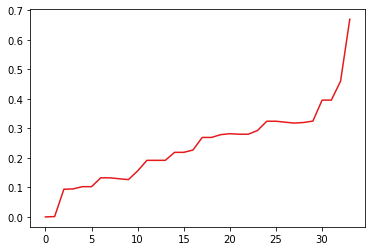

[0.         0.00118885 0.09378084 0.09497417 0.10255877 0.10255877
 0.13254693 0.13254693 0.12943683 0.12653375 0.15593272 0.19176358
 0.1918704  0.1918704  0.21894689 0.21894689 0.22682063 0.26946123
 0.26946123 0.27889731 0.2822079  0.28042175 0.28042175 0.29313936
 0.3244325  0.3244325  0.32115492 0.31813913 0.32019866 0.32492597
 0.39601287 0.39601287 0.46029596 0.67025564]


In [579]:
country1 = "Japan"
i = 0
j = np.zeros(len(country_list)+1)
var = "eq"

for country in country_list:
    if set_variables[country][var]:
        i += df_weights[country][country1] # * df_dom[country].loc[:,"r"]
# print(i)

for gg in range(len(country_list)):
    if set_variables[country_list[gg]][var]:
        j[gg+1] = j[gg]+(df_weights[country_list[gg]][country1] * df_dom[country_list[gg]].loc[:,var][0] / i)
#         print(j[gg],j[gg+1])
#         print()
#         print(df_weights[country_list[gg]][country1] * df_dom[country_list[gg]].loc[:,var][0] / i)
        print(df_weights[country_list[gg]][country1])
        print(df_dom[country_list[gg]].loc[:,var][0])
        
    else:
        j[gg+1] = j[gg]
#         print(country)
# #         j += df_weights[country][country1] * df_domi_unit.loc[:,var]
    
sns.lineplot(data=j)
plt.show()

print(j)

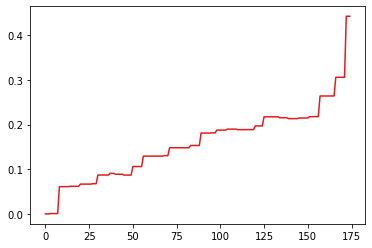

[0.         0.         0.         0.00077376 0.00077376 0.00077376
 0.00077376 0.00077376 0.06103679 0.06103679 0.06103679 0.06103679
 0.06103679 0.06103679 0.06181346 0.06181346 0.06181346 0.06181346
 0.06181346 0.06181346 0.06674986 0.06674986 0.06674986 0.06674986
 0.06674986 0.06674986 0.06674986 0.06759156 0.06759156 0.06759156
 0.0871092  0.0871092  0.0871092  0.0871092  0.0871092  0.0871092
 0.0871092  0.09082788 0.09082788 0.09082788 0.08880368 0.08880368
 0.08880368 0.08880368 0.08880368 0.08691423 0.08691423 0.08691423
 0.08691423 0.08691423 0.1060484  0.1060484  0.1060484  0.1060484
 0.1060484  0.1060484  0.12936874 0.12936874 0.12936874 0.12936874
 0.12936874 0.12936874 0.12943826 0.12943826 0.12943826 0.12943826
 0.12943826 0.12943826 0.13048609 0.13048609 0.13048609 0.14810869
 0.14810869 0.14810869 0.14810869 0.14810869 0.14810869 0.14810869
 0.14810869 0.14810869 0.14810869 0.14810869 0.14810869 0.15323327
 0.15323327 0.15323327 0.15323327 0.15323327 0.15323327 0.180985

In [578]:
sns.lineplot(data=aaa[:,2])
plt.show()
# for i in range(0,5):
#     sns.lineplot(data=aaa[:,i])
#     plt.show()
print(aaa[:,2])

In [98]:
np.where(all_variable_names=='lr_Argentina')


(array([], dtype=int64),)

In [347]:
np.array(dom_variable_list)[set_variables.loc[dom_variable_list][country].tolist()]

array(['y', 'Dp', 'eq', 'r', 'lr'], dtype='<U2')